In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# import seaborn as sns
import tensorflow as tf 
import keras 
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import cv2
import re
import random
random.seed(0)
np.random.seed(0)


In [3]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os


In [4]:
X1=pd.read_csv('Crop_details.csv')
X1=X1.drop('Unnamed: 0',axis=1)


In [5]:

import os
for dirname, _, filenames in os.walk('Users\91966\Desktop\ML\hackathons\agriculture'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

In [6]:
jutepath = "kag2/jute"
maizepath = "kag2/maize"
ricepath = "kag2/rice"
sugarcanepath = "kag2/sugarcane"
wheatpath = "kag2/wheat"

jutefilename = os.listdir(jutepath)
maizefilename = os.listdir(maizepath)
ricefilename = os.listdir(ricepath)
sugarcanefilename = os.listdir(sugarcanepath)
wheatfilename = os.listdir(wheatpath)

X1= []

In [7]:
for fname in jutefilename:
    X1.append([os.path.join(jutepath,fname),0])
for fname in maizefilename:
    X1.append([os.path.join(maizepath,fname),1])
for fname in ricefilename:
    X1.append([os.path.join(ricepath,fname),2])
for fname in sugarcanefilename:
    X1.append([os.path.join(sugarcanepath,fname),3]) 
for fname in wheatfilename:
    X1.append([os.path.join(wheatpath,fname),4])
    
    
X1 = pd.DataFrame(X1,columns = ['path','labels'])  

In [8]:
ohencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohlabel = pd.DataFrame(ohencoder.fit_transform(X1[['labels']]),dtype = 'float64',columns = ['label0','label1','label2','label3','label4'])
label_X1 = X1.copy()
X1 = pd.concat([X1,ohlabel],axis = 1)
new_X1 = X1.drop(['labels'],axis = 1)

In [9]:
train,test = train_test_split(new_X1,test_size=0.2,random_state=32,shuffle = True)

In [10]:
X1_train = train['path'].values
y1_train = train.drop(['path'],axis=1).values
X1_test = test['path'].values
y1_test = test.drop(['path'],axis=1).values

In [11]:
X1_train.shape

(644,)

In [12]:
y1_train.shape

(644, 5)

In [13]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(5, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [14]:
model = create_res_net() # or create_plain_net()
model.summary()

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'cifar-10_res_net_30-'+timestr

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)

model.fit(
    x=X1_train,
    y=y1_train,
    epochs=20,
    verbose=1,
    validation_data=(X1_test, y1_test),
    batch_size=128,
    callbacks=[cp_callback, tensorboard_callback]
)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           conv2d[0][0]                     
_______________________________________________________________________________________

Epoch 1/20


ValueError: in user code:

    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\91966\anaconda3\envs\gputest\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer batch_normalization is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [None, 1]


In [13]:
input_shape = X_train.shape[1:]

NameError: name 'X_train' is not defined

In [14]:
def deep_pipeline(data):
    flat = []
    for i in data:
        img = plt.imread(i)
        img = img/255.
        img=cv2.resize(img,(224,224))
        flat.append(img)
    flat =  np.array(flat)    
    flat = flat.reshape(-1,224,224,3)  
    
    
    return flat
    

In [ ]:
# deep_pipeline('download.jpg')

In [15]:
dx_train = deep_pipeline(X1_train)
dx_test = deep_pipeline(X1_test)

In [16]:
def lr_schedule(epoch): 
    lr = 1e-3
    if epoch > 180: 
        lr *= 0.5e-3
    elif epoch > 160: 
        lr *= 1e-3
    elif epoch > 120: 
        lr *= 1e-2
    elif epoch > 80: 
        lr *= 1e-1
    print('Learning rate: ', lr) 
    return lr 

In [17]:
keras.backend.clear_session()
vgg = keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg.trainable = False
vggmodel = keras.Sequential([vgg
                         ,Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(5,activation='softmax')])

vggmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 1000)              513000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5005      
Total params: 22,544,389
Trainable params: 2,520,005
Non-trainable params: 20,024,384
_________________________________________________________________


In [19]:
hist = vggmodel.fit(dx_train,y1_train,epochs=20,validation_split=0.3,batch_size=16)

Epoch 1/20
29/29 [==============================] - 6s 193ms/step - loss: 2.8990 - accuracy: 0.2867 - val_loss: 1.3819 - val_accuracy: 0.3918
Epoch 2/20
29/29 [==============================] - 5s 157ms/step - loss: 1.1794 - accuracy: 0.5200 - val_loss: 1.4420 - val_accuracy: 0.4278
Epoch 3/20
29/29 [==============================] - 5s 157ms/step - loss: 0.8680 - accuracy: 0.6444 - val_loss: 0.7957 - val_accuracy: 0.7474
Epoch 4/20
29/29 [==============================] - 5s 158ms/step - loss: 0.7608 - accuracy: 0.7356 - val_loss: 1.0514 - val_accuracy: 0.6340
Epoch 5/20
29/29 [==============================] - 5s 158ms/step - loss: 0.6840 - accuracy: 0.7222 - val_loss: 1.6334 - val_accuracy: 0.4948
Epoch 6/20
29/29 [==============================] - 5s 158ms/step - loss: 0.7484 - accuracy: 0.7422 - val_loss: 2.4003 - val_accuracy: 0.4072
Epoch 7/20
29/29 [==============================] - 5s 159ms/step - loss: 0.8660 - accuracy: 0.7000 - val_loss: 0.8675 - val_accuracy: 0.6495
Epoch 

In [22]:
score = vggmodel.evaluate(dx_test,y1_test)
print("accuracy: ", score[1])

6/6 [==============================] - 1s 233ms/step - loss: 0.4700 - accuracy: 0.8882
accuracy:  0.888198733329773


In [23]:
pred = vggmodel.predict(dx_test)
prediction = np.argmax(pred,axis=1)
true = np.argmax(y1_test,axis=1)
best_prob = [pred[num,:][i] for num,i in enumerate(prediction)]

In [24]:

def deepmodelpipeline(imagepath,model = vggmodel,label=[-1]):
    pdict = {0:"jute",1:"maize",2:"rice",3:"sugarcane",4:"wheat"}
    pred_x = deep_pipeline([imagepath])
    prediction = model.predict(pred_x)
    pred = np.argmax(prediction[0])
    plt.imshow(plt.imread(imagepath))
    if (label[0]!=-1):
        plt.title("prediction : {0} % {1:.2f} \ntrue   : {2}".format(pdict[pred],prediction[0,pred]*100,pdict[np.argmax(label)]))
    else:
        plt.title("prediction : {0}, % {1:.2f}".format(pdict[pred],prediction[0,pred]*100))

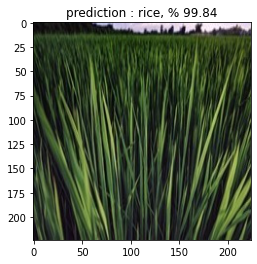

In [25]:
deepmodelpipeline('kag2/rice/rice024ahs.jpeg')

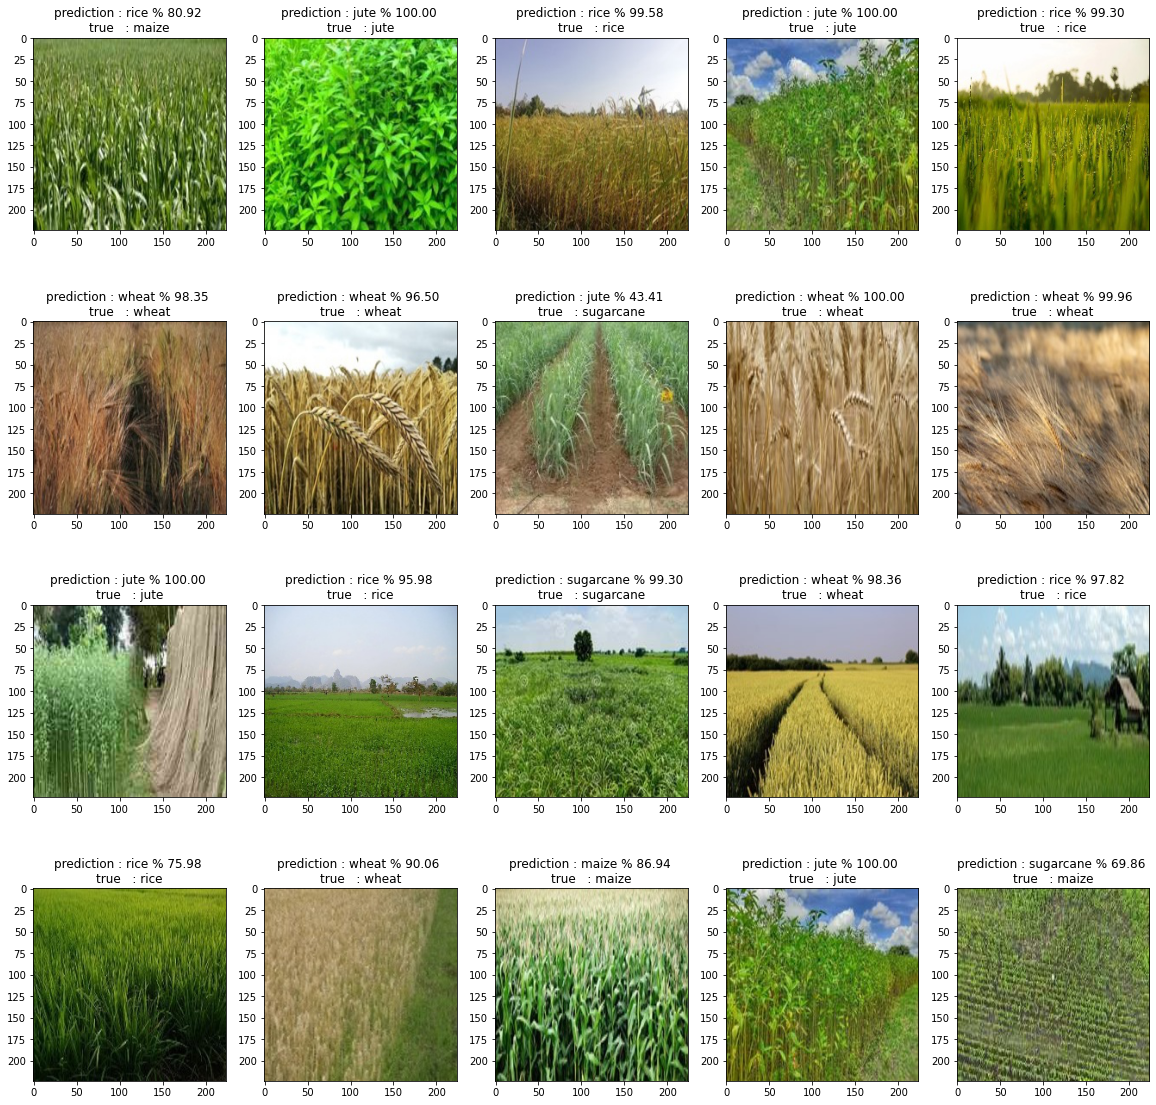

In [28]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X1_test[0:20]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y1_test[num])

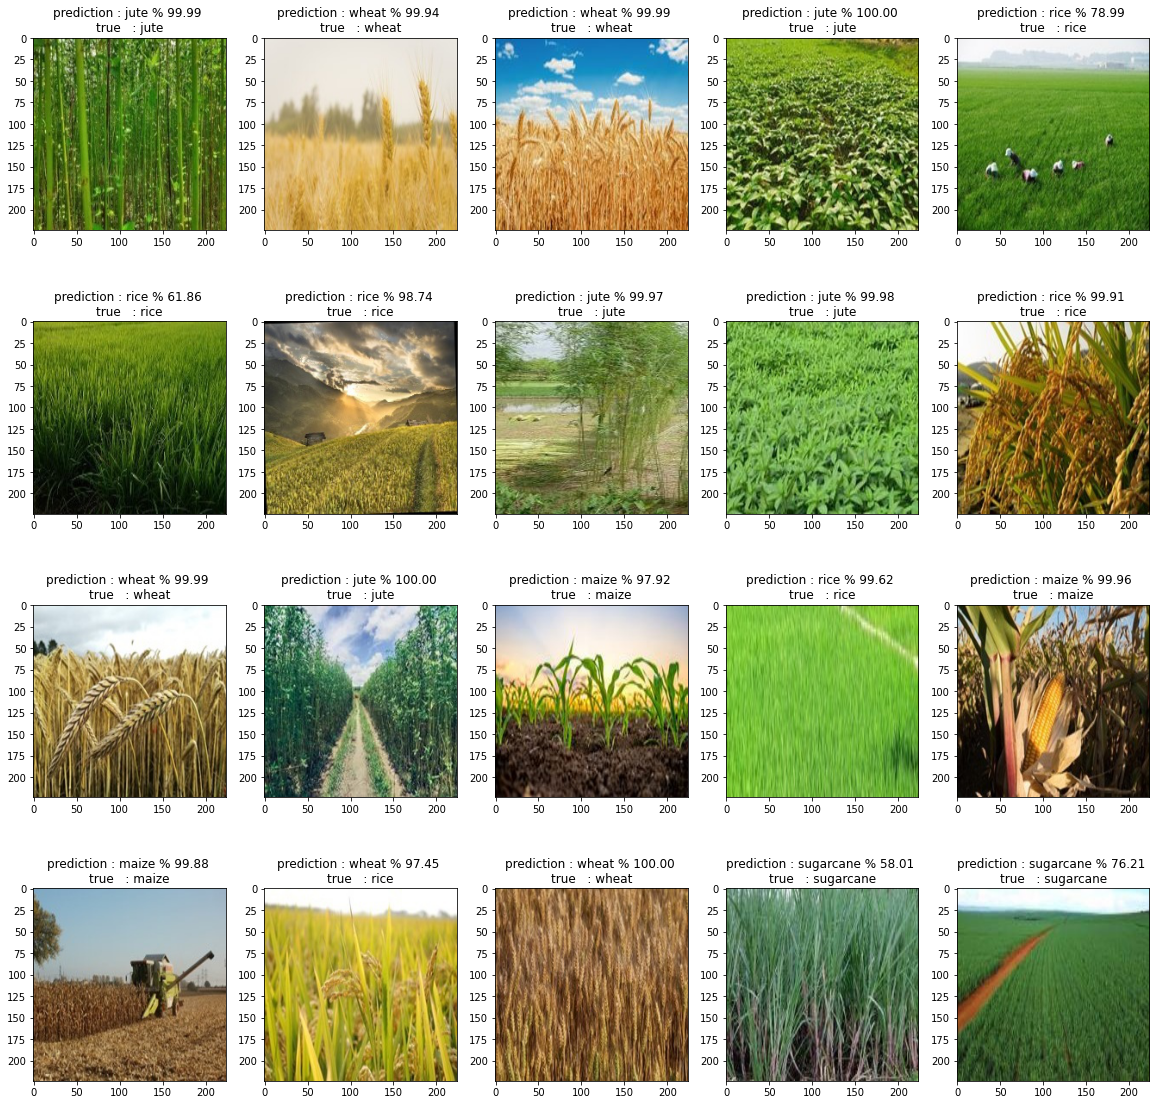

In [29]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X1_test[20:40]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y1_test[num+20])

In [30]:
vggmodel.save_weights("vggmodelweight.h5")

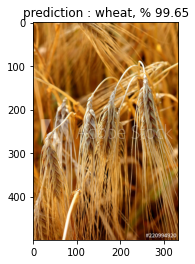

In [31]:
deepmodelpipeline('download.jpg')